# Ladenie modelov BERT na klasifikáciu textu verejných obstarávaní do 2. úrovne CPV

## Načítanie a predspracovanie dát

Použitím knižnice **Pandas** sme do štruktúry DataFrame načítali trénovacie a testovacie dáta zo štruktúrovaného formátu CSV.

In [1]:
# Nacitanie CSV suborov s treningovou a testovacou mnozinou dat
import pandas as pd

df_train = pd.read_csv("preklad_train_final.csv", header=0, index_col=0)
df_test = pd.read_csv("preklad_test_final.csv", header=0, index_col=0)

In [2]:
# Definovanie nazvov stlpcov s textom verejnych zakaziek a ich cielovymi triedami (label)
column_text, column_label = "cs_title_with_description", "cpv_level2_label"

In [3]:
# Definovanie nazvu jazykoveho modelu na tokenizaciu textov a nasledny proces fine-tuning
bert_model = "UWB-AIR/Czert-B-base-cased"

Po načítaní trénovacích a testovacích dát  sme vypísali prvých 5 záznamov z oboch dátových súborov a súčasne aj prvé tri hodnoty s najvyšším počtom výskytov a posledné tri hodnoty s najnižším počtom výskytov zo stĺpca cieľovej triedy (*cpv_label*).

In [4]:
def df_info_label(dataframe):
    print(dataframe.shape)
    display(dataframe.head())
    print(dataframe[column_label].value_counts().head(3))
    print(dataframe[column_label].value_counts().tail(3))

In [5]:
# Vypis ukazky treningovych dat, troch tried s najvacsim aj najmensim poctom zaznamov
df_info_label(df_train)

(35446, 7)


,cs_title_with_description,en_title_with_description,cpv_full_code,cpv_level1,cpv_level1_label,cpv_level2,cpv_level2_label
index,,,,,,,
0,Forenzní software Předmětem plnění veřejné zak...,Forensic software The subject of the performan...,48900000-7,48000000-8,23,48900000-7,135
1,REKONSTRUKCE UČEBEN PRO VÝUKU CIZÍCH JAZYKŮ A ...,RECONSTRUCTION OF CLASSROOMS FOR THE TEACHING ...,39162000-5,39000000-2,17,39100000-3,93
2,Multifunkční hala Výstavba nové multifukční sp...,Multifunctional hall Construction of a new mul...,45212225-9,45000000-7,22,45200000-9,124
3,část 2-SO2 (obvod Správy tratí České Budějovic...,part 2-SO2 (district of the Railway Administra...,50225000-8,50000000-5,24,50200000-7,137
4,Erlotinib Předmětem této části veřejné zakázky...,Erlotinib The subject of this part of the publ...,33652000-5,33000000-0,12,33600000-6,63


cpv_level2_label
124    4357
62     4232
63     2929
Name: count, dtype: int64
cpv_level2_label
193    1
83     1
223    1
Name: count, dtype: int64


In [6]:
# Vypis ukazky testovacich dat, troch tried s najvacsim aj najmensim poctom zaznamov
df_info_label(df_test)

(15192, 7)


,cs_title_with_description,en_title_with_description,cpv_full_code,cpv_level1,cpv_level1_label,cpv_level2,cpv_level2_label
index,,,,,,,
0,KoPÚ v k. ú. Hostouň u Horšovského Týna a Tasn...,KoPÚ in the district of Hostouň near Horšovské...,71250000-5,71000000-8,33,71200000-0,172
1,Dodávky izolátorů VVN keramických podpěrných p...,Supply of VHV ceramic support insulators for s...,44111511-6,44000000-0,21,44100000-1,115
2,FNUSA - Nábytkové vybavení - objekt P Předměte...,FNUSA - Furniture equipment - object P The sub...,39130000-2,39000000-2,17,39100000-3,93
3,Část 3 - Monitory Monitory,Part 3 - Monitors Monitors,30231310-3,30000000-9,9,30200000-1,50
4,"Oprava silnice II/606, Pomezí nad Ohří - SO 10...","Repair of road II/606, Pomezí nad Ohří - SO 10...",45233140-2,45000000-7,22,45200000-9,124


cpv_level2_label
124    1868
62     1814
63     1256
Name: count, dtype: int64
cpv_level2_label
179    1
14     1
193    1
Name: count, dtype: int64


In [7]:
# Vytvorenie slovnika dvojic kodov CPV na druhej a prvej urovni hierarchie
if "cpv_level2_label" in df_train.columns:
    paired_cpv_levels = dict(zip(df_train["cpv_level2_label"], df_train["cpv_level1_label"]))
    print(paired_cpv_levels)

{135: 23, 93: 17, 124: 22, 137: 24, 63: 12, 51: 10, 197: 38, 5: 1, 200: 39, 173: 33, 87: 16, 104: 19, 72: 13, 116: 21, 157: 27, 62: 12, 140: 24, 144: 25, 225: 43, 220: 42, 221: 42, 218: 42, 94: 17, 50: 9, 68: 13, 49: 9, 66: 13, 73: 13, 125: 22, 228: 44, 172: 33, 134: 23, 132: 23, 88: 16, 56: 10, 89: 16, 30: 5, 3: 0, 181: 34, 74: 14, 163: 29, 126: 22, 198: 38, 107: 19, 6: 1, 136: 24, 71: 13, 96: 17, 180: 34, 57: 10, 44: 8, 28: 5, 208: 39, 138: 24, 117: 21, 154: 27, 103: 19, 139: 24, 143: 24, 205: 39, 168: 31, 212: 40, 105: 19, 201: 39, 170: 32, 123: 22, 110: 20, 59: 11, 7: 2, 206: 39, 54: 10, 216: 41, 52: 10, 202: 39, 76: 14, 204: 39, 4: 1, 187: 35, 80: 15, 86: 16, 192: 36, 162: 29, 61: 11, 207: 39, 120: 21, 203: 39, 115: 21, 29: 5, 46: 8, 31: 5, 111: 20, 176: 33, 79: 14, 36: 6, 55: 10, 98: 17, 67: 13, 174: 33, 194: 37, 64: 12, 161: 28, 217: 42, 210: 40, 131: 23, 215: 41, 42: 7, 92: 16, 95: 17, 22: 4, 27: 4, 195: 37, 97: 17, 81: 15, 130: 23, 219: 42, 127: 23, 33: 5, 10: 2, 191: 36, 1: 0

In [8]:
train_labels = df_train[column_label].tolist()
train_text = df_train[column_text].tolist()

test_labels = df_test[column_label].tolist()
test_text = df_test[column_text].tolist()

## Tokenizácia textov

Použitím knižnice **Logging** sme nastavili úroveň zaznamenávania logov pri procese tokenizácie textu s knižnicou Transformers. Nastavenie *logging.ERROR* špecifikuje, že budú zaznamenané a zobrazené varovania (napr. v prípade použitia jazykového modelu s maximálnou dĺžkou sekvencie 512 tokenov, ak bude vstupná sekvencia dlhšia).

In [9]:
import logging

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

Použitím knižnice **Transformers**, ktorá v našej práci slúži na prácu s modelmi hlbokého učenia pre spracovanie prirodzeného jazyka, sme vytvorili objekt *tokenizer*. Tokenizér, ktorý zodpovedá požadovanému modelu BERT, sme v ďalšom kroku použili na tokenizáciu textu pomocou predtrénovaného jazykového modelu. Úloha tokenizéra spočíva v rozdelení textu na tokeny, ktoré je možné ďalej použiť na vytvorenie vstupu pre jazykový model BERT alebo na ďalšie spracovanie textu.

In [10]:
# Tokenizacia vstupnych textov - nazvy a popisy verejnych obstaravani
import transformers
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(bert_model, do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/214k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Po tokenizácii textu sme vypísali pôvodné znenie jednej vety s počtom jej znakov, vetu rozdelenú na tokeny s počtom tokenov a namapované identifikátory týchto tokenov.

In [11]:
# Vypis textu zakazky, jednotlivych tokenov a ich identifikatorov po tokenizacii
sentence_index = 10

sentence = train_text[sentence_index]

print(f"Text zakazky ma {len(sentence)} znakov:")
print(sentence)
print("")

print(f"Text zakazky ma {len(tokenizer.tokenize(sentence))} tokenov:")
print(tokenizer.tokenize(sentence))
print("")

print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

Text zakazky ma 228 znakov:
Poskytování právních služeb Předmětem zadávacího řízení je výběr tří dodavatelů, se kterými bude uzavřena rámcová smlouva o poskytování právních služeb podle zákona č. 85/1996 Sb., zákon o advokacii, ve znění pozdějších předpisů

Text zakazky ma 49 tokenov:
['Pos', '##ky', '##tová', '##ní', 'právních', 'služeb', 'Před', '##mět', '##em', 'zadá', '##vacího', 'řízení', 'je', 'výběr', 'tří', 'dodavatelů', ',', 'se', 'kterými', 'bude', 'uzavřena', 'rám', '##cová', 'smlouva', 'o', 'poskytování', 'právních', 'služeb', 'podle', 'zákona', 'č', '.', '85', '/', '1996', 'Sb', '.', ',', 'zákon', 'o', 'advok', '##aci', '##i', ',', 've', 'znění', 'pozdější', '##ch', 'předpisů']

[12780, 1988, 13263, 1930, 20305, 5050, 3256, 13765, 1941, 13359, 21743, 4015, 1955, 6571, 3371, 29729, 16, 1940, 8352, 2190, 14165, 3652, 8588, 10326, 83, 18814, 20305, 5050, 2249, 4191, 187, 18, 8990, 19, 9569, 14097, 18, 16, 2831, 83, 8516, 2559, 1007, 16, 2043, 17118, 11912, 1928, 18797]


## Formátovanie vstupných viet pre klasifikáciu

Jazykový model BERT si pre spracovanie textu vyžaduje pridanie špeciálnych tokenov na začiatok a koniec textu – [CLS] a [SEP]. Tieto tokeny sú reprezentované identifikátormi 101 a 102 a do výstupu sa vkladajú automaticky. Proces pozostáva z rozdelenia vety na tokeny, pridania špeciálnych tokenov a namapovanie na ich identifikátory. 

In [12]:
def text_to_token_id(tokenizer, text_list):
    ids_list = []
    
    for item in text_list:
        encoded_item = tokenizer.encode(item, add_special_tokens=True)
        ids_list.append(encoded_item)
    return ids_list

In [13]:
train_text_ids = text_to_token_id(tokenizer, train_text)

In [14]:
test_text_ids = text_to_token_id(tokenizer, test_text)

In [15]:
print(f"Text zakazky ma {len(sentence)} znakov:")
print(sentence)
print("")

sentence_ids = train_text_ids[sentence_index]

print(f"Text zakazky ma {len(sentence_ids)} tokenov (so specialnymi CLS a SEP):")
print(sentence_ids)

Text zakazky ma 228 znakov:
Poskytování právních služeb Předmětem zadávacího řízení je výběr tří dodavatelů, se kterými bude uzavřena rámcová smlouva o poskytování právních služeb podle zákona č. 85/1996 Sb., zákon o advokacii, ve znění pozdějších předpisů

Text zakazky ma 51 tokenov (so specialnymi CLS a SEP):
[2, 12780, 1988, 13263, 1930, 20305, 5050, 3256, 13765, 1941, 13359, 21743, 4015, 1955, 6571, 3371, 29729, 16, 1940, 8352, 2190, 14165, 3652, 8588, 10326, 83, 18814, 20305, 5050, 2249, 4191, 187, 18, 8990, 19, 9569, 14097, 18, 16, 2831, 83, 8516, 2559, 1007, 16, 2043, 17118, 11912, 1928, 18797, 3]


V ďalšom kroku sme vypísali identifikátor tokenu, ktorý sa vyskytol najčastejšie v trénovacej a testovacej množine dát.

In [16]:
# Vypis identifikatora tokenu s najvacsim vyskytom v treningovej a testovacej mnozine
from collections import Counter

def common_token_id(list):
    all_tokens = [token for llist in list for token in llist]
    counts = Counter(all_tokens)
    common_token, count = counts.most_common(1)[0]
    print(f"ID tokenu s najvacsim vyskytom: {common_token}")
    return common_token

In [17]:
common_token = common_token_id(train_text_ids)

ID tokenu s najvacsim vyskytom: 18


In [18]:
common_token = common_token_id(test_text_ids)

ID tokenu s najvacsim vyskytom: 18


V ďalšom kroku sme vypísali najväčší a najmenší počet tokenov z viet, ktoré sa nachádzali v trénovacej a testovacej množine dát. 

In [19]:
train_lengths = [len(sentence) for sentence in train_text_ids]
print(f"Najvacsi pocet tokenov textu v trenovacej mnozine: {max(train_lengths)} [index: {train_lengths.index(max(train_lengths))}]")
print(f"Najmensi pocet tokenov textu v trenovacej mnozine: {min(train_lengths)} [index: {train_lengths.index(min(train_lengths))}]")
print("")

test_lengths = [len(sentence) for sentence in test_text_ids]
print(f"Najvacsi pocet tokenov textu v testovacej mnozine: {max(test_lengths)} [index: {test_lengths.index(max(test_lengths))}]")
print(f"Najmensi pocet textu v testovacej mnozine: {min(test_lengths)} [index: {test_lengths.index(min(test_lengths))}]")

Najvacsi pocet tokenov textu v trenovacej mnozine: 437 [index: 33463]
Najmensi pocet tokenov textu v trenovacej mnozine: 4 [index: 27717]

Najvacsi pocet tokenov textu v testovacej mnozine: 454 [index: 13469]
Najmensi pocet textu v testovacej mnozine: 4 [index: 341]


### Padding a Truncating vstupných textov

Zistili sme, že vety majú rôzne dĺžky, a preto sme pokračovali aplikovaním metódy *padding/truncating* na vytvorenie rovnako dlhých sekvencií textu. Ak je dĺžka kratšia, pridáva sa špeciálny token, aby kratšie sekvencie mali požadovanú dĺžku. V opačnom prípade, ak sú sekvencie dlhšie ako je požadovaná dĺžka, jednoducho sa skrátia. Rozhranie API podporuje viacero stratégií, ktorými môžeme tento proces vykonať.

In [20]:
def padding_and_truncating(input_ids_list, max_length):
    processed_input_ids_list = []
    
    for item in input_ids_list:
        if len(item) < max_length:
            padding_length = max_length - len(item)
            item += [0] * padding_length
        elif len(item) >= max_length:
            item = item[:max_length]

        processed_input_ids_list.append(item)

    return processed_input_ids_list

In [21]:
max_length = 256

train_padding_list = padding_and_truncating(train_text_ids, max_length=max_length)
test_padding_list = padding_and_truncating(test_text_ids, max_length=max_length)

In [22]:
sentence_padded_ids = train_padding_list[sentence_index]

print(f"Text zakazky ma po uprave {len(sentence_padded_ids)} tokenov:")
print(sentence_padded_ids)

Text zakazky ma po uprave 256 tokenov:
[2, 12780, 1988, 13263, 1930, 20305, 5050, 3256, 13765, 1941, 13359, 21743, 4015, 1955, 6571, 3371, 29729, 16, 1940, 8352, 2190, 14165, 3652, 8588, 10326, 83, 18814, 20305, 5050, 2249, 4191, 187, 18, 8990, 19, 9569, 14097, 18, 16, 2831, 83, 8516, 2559, 1007, 16, 2043, 17118, 11912, 1928, 18797, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Hodnoty *Attention-masks*

Hodnoty Attention masks nám pomáhajú určiť, ktoré tokeny v sekvencii predstavujú skutočné slová a ktoré slúžia len ako umelá výplň sekvencie. V prípade použita jazykového modelu BERT sme to mali jednoduché, nakoľko nepoužíva identifikátor 0. To znamená, že ak je ID tokenu 1, token je skutočný a ak je ID tokenu 0, ide o umelo doplnený token.

Pre tokeny, ktoré predstavovali skutočné slová, sme nastavili hodnotu Attention mask = 1 a pre ostatné, ktoré slúžili len ako umelá výplň sekvencie, sme nastavili hodnotu Attention mask = 0.

In [23]:
def get_attention_masks(pad_input_ids_list):

    attention_masks_list = []

    for item in pad_input_ids_list:
        mask_list = []
        for subitem in item:
            if subitem > 0:
                mask_list.append(1)
            else:
                mask_list.append(0)
        attention_masks_list.append(mask_list)

    return attention_masks_list

In [24]:
train_attention_masks = get_attention_masks(train_padding_list)

In [25]:
test_attention_masks = get_attention_masks(test_padding_list)

## Rozdelenie datasetu na trénovaciu a validačnú množinu

Použitím knižnice **Scikit-Learn** sme trénovacie dáta rozdelili na trénovaciu množinu (90 %) a validačnú množinu (10 %). Počet záznamov v testovacej množine ostal nezmenený.

In [26]:
# Vytvorenie validacnej mnoziny dat, ktora pochadza oddelenim 10 % z dat v treningovej mnozine
from sklearn.model_selection import train_test_split

train_size = 0.9
train_padding_list, validation_padding_list, train_labels, validation_labels, train_attention_masks, validation_attention_masks = train_test_split(train_padding_list, train_labels, train_attention_masks, train_size=train_size, random_state=2024)

In [27]:
print(f"Pocet trenovacich prikladov: {len(train_labels)}")
print(f"Pocet validacnych prikladov: {len(validation_labels)}")
print(f"Pocet testovacich prikladov: {len(test_labels)}")

Pocet trenovacich prikladov: 31901
Pocet validacnych prikladov: 3545
Pocet testovacich prikladov: 15192


Použitím knižnice **Torch**, ktorá nám slúži pre prácu s tenzormi, sme vytvorili premenné *inputs*, *labels* a *masks* pre trénovaciu, validačnú aj testovaciu množinu. Obsahujú dáta pre vstup, označenia cieľových tried a Attention masks. Tieto dáta sme pôvodne mali uložené v zoznamoch, a preto sme ich konvertovali na torch tenzory, ktoré sú potrebné ako vstup pre model klasifikácie.

In [28]:
# Vytvorenie tenzorov pre treningovu, validacnu a testovaciu mnozinu dat
import torch

train_inputs = torch.tensor(train_padding_list)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_attention_masks)

validation_inputs = torch.tensor(validation_padding_list)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_attention_masks)

test_inputs = torch.tensor(test_padding_list)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)

Pokračovali sme definovaním hodnoty premennej *batch_size*, ktorá určuje veľkosť dávky, ktorá sa použije pri trénovaní modelu.

In [29]:
# Definovanie velkosti davky na trening jazykoveho modelu (batch size)
batch_size = 32

Použitím knižnice **Torch**, ktorá nám slúži pre prácu s tenzormi, sme v ďalšom kroku vytvorili objekty typu *DataLoader* pre trénovaciu, validačnú aj testovaciu množinu dát.

In [30]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [31]:
len(train_dataloader)

997

## Tréning klasifikačného modelu BERT

Pred tréningom modelu klasifikácie textu sme overili, či máme k dispozícii GPU a nastavili zariadenie podľa toho, či je CUDA dostupná.

In [32]:
# Urcenie zariadenia na vykonanie ladenia jazykoveho modelu - CPU alebo CUDA (praca s GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Použitím knižnice **Transformers** sme pokračovali sme načítaním predtrénovaného jazykového modelu BERT. Určili sme hodnotu parametra *num_labels*, ktorý určuje počet tried pre klasifikáciu textu.

In [33]:
# Nacitanie predtrenovaneho jazykoveho modelu BERT z platformy Hugging Face
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=230, output_attentions=False, output_hidden_states=False)

model.to(device)

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UWB-AIR/Czert-B-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Po načítaní nami zvoleného jazykového modelu BERT potrebujeme nastaviť hodnoty hyperparametrov pre trénovanie – počet *epoch* a *learning_rate*.

In [34]:
# Definovanie poctu epoch na ladenie jazykoveho modelu a rychlosti ucenia (learning rate)
epochs = 2
learning_rate = 3e-5

V ďalšom kroku sme vytvorili inštanciu optimalizátora AdamW s nastavenými parametrami *learning_rate*, ktorý určuje rýchlosť učenia, a *epsilon*.

In [35]:
# Vytvorenie instancie optimalizacneho algoritmu Adam
import torch.optim

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Po konfigurácii optimalizátora sme pokračovali nastavením plánovača učenia, ktorý zohľadňuje hodnotu *learning_rate*. Vypočítali sme celkový počet krokov trénovania ako súčin počtu dávok (batches) a počtu epoch, ktorý sa použije na nastavenie plánovača učenia. Po vypočítaní sme počet krokov trénovania vypísali aj s počtom krokov v jednej epoche.

In [36]:
# Vypocet pocet krokov trenovania a nastavenie planovaca ucenia modelu
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
print(f"Pocet krokov trenovania: {total_steps} (v jednej epoche: {int(total_steps / epochs)})")

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Pocet krokov trenovania: 1994 (v jednej epoche: 997)


### Proces trénovania modelu klasifikácie (fine-tuning)

Hodnotu *seed*, ktorá bude použitá pre inicializáciu náhodného generátora a súčasne zabezpečí, aby bol proces opätovne reprodukovateľný, sme nastavili na 2024.

In [37]:
import numpy as np
import random

seed = 2024

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Použitím knižnice **Torch** sme určili funkciu *CrossEntropyLoss* na výpočet straty (chyby) medzi predikciami modelu a skutočnými triedami v rámci trénovacieho procesu jazykového modelu.

In [38]:
# Inicializacia stratovej funkcie krizovej entropie (CrossEntropyLoss) 
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

Pred procesom tréningu sme vytvorili zoznamy na ukladanie hodnôt *training_loss*, *validation_loss* a *accuracy*, aby sme po skončení procesu mohli dosiahnuté hodnoty vizuálne znázorniť.

In [39]:
train_loss_values = []
validation_loss_values = []
accuracy_values = []

**Proces tréningu a validácie jazykového modelu BERT**

In [40]:
import datetime, os, time

for epoch_i in range(epochs):

    # Proces trenovania jazykoveho modelu BERT
    print("TRAIN starting ---->")
    print(f"... Epoch {epoch_i + 1} of {epochs} ...")

    total_train_loss = 0
    
    t0 = time.time()

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and step != 0:
            step_elapsed = int(round((time.time() - t0)))
            step_elapsed_time = datetime.timedelta(seconds=step_elapsed)
            print(f"Epoch {epoch_i + 1} | Batch {step} of {len(train_dataloader)} | Total time {step_elapsed_time}")

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        train_loss = outputs[0]
        total_train_loss += train_loss.item()

        train_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    epoch_elapsed = int(round((time.time() - t0)))
    epoch_elapsed_time = datetime.timedelta(seconds=epoch_elapsed)

    print("")
    print(f"Average training loss: {round(avg_train_loss, 3)}")
    print(f"Training (epoch {epoch_i + 1}) - total time: {epoch_elapsed_time}")
    print("")

    # Proces validacie jazykoveho modelu BERT
    print("VALIDATION starting ---->")

    t0 = time.time()

    model.eval()

    eval_accuracy, nb_eval_steps = 0, 0
    total_validation_loss, total_batches = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        validation_loss = criterion(logits, b_labels)
        total_validation_loss += validation_loss.item() 
        total_batches += 1

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        tmp_eval_accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    avg_validation_loss = total_validation_loss / total_batches
    validation_loss_values.append(avg_validation_loss)
    
    accuracy = eval_accuracy / nb_eval_steps
    accuracy_values.append(accuracy)

    validation_elapsed = int(round((time.time() - t0)))
    validation_elapsed_time = datetime.timedelta(seconds=validation_elapsed)

    print(f"Accuracy: {round(accuracy, 3)}")
    print(f"Average validation loss: {round(avg_validation_loss, 3)}")
    print(f"Validation - total time: {validation_elapsed_time}")
    print("____________________")
    
    saved_model_dir = "./saved_model" + str(epoch_i)

    if not os.path.exists(saved_model_dir):
        os.makedirs(saved_model_dir)
        print("Model with tokenizer saved:", saved_model_dir)
    model.save_pretrained(saved_model_dir)
    tokenizer.save_pretrained(saved_model_dir)

TRAIN starting ---->
... Epoch 1 of 2 ...
Epoch 1 | Batch 10 of 997 | Total time 0:00:08
Epoch 1 | Batch 20 of 997 | Total time 0:00:15
Epoch 1 | Batch 30 of 997 | Total time 0:00:23
Epoch 1 | Batch 40 of 997 | Total time 0:00:30
Epoch 1 | Batch 50 of 997 | Total time 0:00:38
Epoch 1 | Batch 60 of 997 | Total time 0:00:45
Epoch 1 | Batch 70 of 997 | Total time 0:00:52
Epoch 1 | Batch 80 of 997 | Total time 0:01:00
Epoch 1 | Batch 90 of 997 | Total time 0:01:07
Epoch 1 | Batch 100 of 997 | Total time 0:01:15
Epoch 1 | Batch 110 of 997 | Total time 0:01:22
Epoch 1 | Batch 120 of 997 | Total time 0:01:30
Epoch 1 | Batch 130 of 997 | Total time 0:01:37
Epoch 1 | Batch 140 of 997 | Total time 0:01:45
Epoch 1 | Batch 150 of 997 | Total time 0:01:52
Epoch 1 | Batch 160 of 997 | Total time 0:01:59
Epoch 1 | Batch 170 of 997 | Total time 0:02:07
Epoch 1 | Batch 180 of 997 | Total time 0:02:14
Epoch 1 | Batch 190 of 997 | Total time 0:02:22
Epoch 1 | Batch 200 of 997 | Total time 0:02:29
Epoch 1

Po ukončení procesu tréningu sme vypísali a použitím knižnice **MatPlotLib** vizuálne znázornili hodnoty *training_loss* a *validation_loss*, ktoré sme dosiahli počas trénovania jazykového modelu po jednotlivých epochách.

In [41]:
print(f"Training loss: {train_loss_values}")

Training loss: [1.9758706627303404, 1.0771842393557072]


In [42]:
print(f"Validation loss: {validation_loss_values}")

Validation loss: [1.224834591955752, 1.0448054263183661]


In [43]:
print(f"Accuracy: {accuracy_values}")

Accuracy: [0.7446171171171172, 0.7733783783783784]


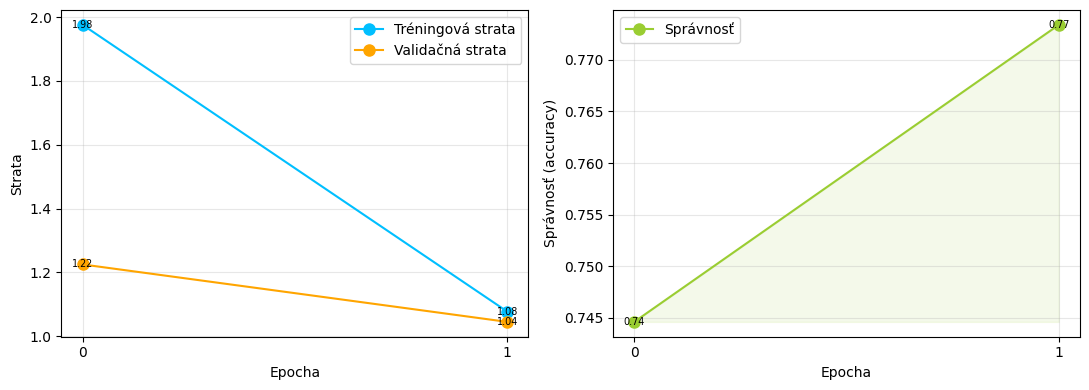

In [44]:
# Vizualizacia krivky hodnot treningovej a validacnej straty po jednotlivych epochach
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(11, 4))

axs[0].plot(train_loss_values, linestyle="solid", marker="o", markersize=8, color="deepskyblue", mfc="deepskyblue")
for i, loss in enumerate(train_loss_values):
    axs[0].text(i, loss, f"{loss:.2f}", ha="center", va="center", fontsize="x-small")

axs[0].plot(validation_loss_values, linestyle="solid", marker="o", markersize=8, color="orange", mfc="orange")
for i, loss in enumerate(validation_loss_values):
    axs[0].text(i, loss, f"{loss:.2f}", ha="center", va="center", fontsize="x-small")

axs[0].set_xlabel("Epocha")
axs[0].set_xticks(np.arange(len(train_loss_values)))
axs[0].set_ylabel("Strata")
axs[0].legend(["Tréningová strata", "Validačná strata"])
axs[0].grid(True, alpha=0.3)


axs[1].plot(accuracy_values, linestyle="solid", marker="o", markersize=8, mfc="yellowgreen", color="yellowgreen")

for i, loss in enumerate(accuracy_values):
    axs[1].text(i, loss, f"{loss:.2f}", ha="center", va="center", fontsize="x-small")

axs[1].fill_between(range(len(accuracy_values)), accuracy_values, min(accuracy_values), color="yellowgreen", alpha=0.1)

axs[1].set_xlabel("Epocha")
axs[1].set_xticks(np.arange(len(accuracy_values)))
axs[1].set_ylabel("Správnosť (accuracy)")
axs[1].legend(["Správnosť"])
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Proces testovania modelu klasifikácie (fine-tuning)

**Proces testovania a vyhodnotenia dosiahnutých výsledkov klasifikácie textu verejných zákaziek**

In [45]:
labels_true = np.empty(0)
labels_predict = np.empty(0)

In [46]:
# Proces testovania doladeneho jazykoveho modelu BERT
print("TEST starting ---->")

model.eval()

correct, index = 0, 0

for batch in test_dataloader:

    index += 1

    batch = tuple(b.to(device) for b in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    pred = np.argmax(logits.cpu().numpy(), axis=1)
    b_labels = b_labels.cpu().numpy().astype(int)

    correct += (pred == b_labels).sum()
    
    labels_true = np.concatenate((labels_true, b_labels))
    labels_predict = np.concatenate((labels_predict, pred))

print(f"Total correct: {correct} of {len(test_inputs)}")
print(f"Test accuracy: {round((correct / len(test_inputs)), 3)}")

TEST starting ---->
Total correct: 11636 of 15192
Test accuracy: 0.766


Použitím knižnice **Scikit-Learn** sme dosiahnuté výsledky vyhodnotili prostredníctvom metrík *precision*, *recall* a *f1-score* – s mikro- aj makro- priemerovaním.

In [48]:
# Vypocet mikro- a makro-metrik spravnosti, presnosti, navratnosti a F1-skore
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(labels_true, labels_predict)
macro_precision = precision_score(labels_true, labels_predict, average="macro", zero_division=0)
macro_recall = recall_score(labels_true, labels_predict, average="macro")
macro_f1 = f1_score(labels_true, labels_predict, average="macro")

print(f"Accuracy: {round(accuracy, 3)}")
print(f"Precision: {round(macro_precision, 3)}")
print(f"Recall: {round(macro_recall, 3)}")
print(f"F1-score: {round(macro_f1, 3)}")

Accuracy: 0.766
Precision: 0.336
Recall: 0.291
F1-score: 0.289


In [49]:
micro_precision = precision_score(labels_true, labels_predict, average="micro", zero_division=0)
micro_recall = recall_score(labels_true, labels_predict, average="micro")
micro_f1 = f1_score(labels_true, labels_predict, average="micro")

print(f"Accuracy: {round(accuracy, 3)}")
print(f"Precision: {round(micro_precision, 3)}")
print(f"Recall: {round(micro_recall, 3)}")
print(f"F1-score: {round(micro_f1, 3)}")

Accuracy: 0.766
Precision: 0.766
Recall: 0.766
F1-score: 0.766


Použitím knižníc **Scikit-Learn** a **Pandas** sme vypísali klasifikačný report, ktorý pozostával z vypočítaných metrík *precision*, *recall* a *f1-score* pre jednotlivé cieľové triedy.

In [50]:
# Vypis dosiahnutych hodnot metrik pre jednotlive skupiny schemy CPV (na druhej urovni)
from sklearn.metrics import classification_report

report = classification_report(labels_true, labels_predict, zero_division=0, output_dict=True)

df_classification_report = pd.DataFrame(report).transpose()
df_classification_report = df_classification_report.drop(df_classification_report.iloc[len(df_classification_report):].index)
df_classification_report.reset_index(drop=True, inplace=True)
df_classification_report["support"] = df_classification_report["support"].astype(int)

display(df_classification_report.style.background_gradient(subset=["precision", "recall", "f1-score"], vmin=0, vmax=1))

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,5
1,0.000000,0.000000,0.000000,5
2,1.000000,0.700000,0.823529,10
3,0.142857,0.071429,0.095238,14
4,0.893004,0.986364,0.937365,220
5,0.818182,0.729730,0.771429,37
6,0.938697,0.910781,0.924528,269
7,0.822222,0.973684,0.891566,38
8,0.000000,0.000000,0.000000,2
9,0.000000,0.000000,0.000000,3


In [51]:
cpv_level1_ids = ["03", "09", "14", "15", "16", "18", "19", "22", "24", "30", "31", "32", "33", "34", "35", "37", "38", "39", "41", "42", "43", "44", "45", "48", "50", "51", "55", "60", "63", "64", "65", "66", "70", "71", "72", "73", "75", "76", "77", "79", "80", "85", "90", "92", "98"]

In [52]:
# Vypis dosiahnutych hodnot metrik pre jednotlive oddiely schemy CPV (na prvej urovni)
df_metrics = df_classification_report.copy()
df_metrics["label_index"] = df_metrics.index.map(paired_cpv_levels)

df_metrics = df_metrics.groupby("label_index").agg({"precision": "mean", "recall": "mean", "f1-score": "mean", "support": "sum"})
df_metrics["cpv_level1_id"] = cpv_level1_ids
df_metrics.reset_index(drop=True, inplace=True)

display(df_metrics.style.background_gradient(subset=["precision", "recall", "f1-score"], vmin=0, vmax=1))

,precision,recall,f1-score,support,cpv_level1_id
0,0.285714,0.192857,0.229692,34,03
1,0.883294,0.875625,0.877774,526,09
2,0.137037,0.162281,0.148594,51,14
3,0.305750,0.300505,0.291722,74,15
4,0.093750,0.153846,0.116505,73,16
5,0.484150,0.274587,0.303513,172,18
6,0.333333,0.074074,0.121212,39,19
7,0.166667,0.133333,0.148148,50,22
8,0.402834,0.515909,0.450363,158,24
9,0.786937,0.853549,0.818888,776,30


In [54]:
np.savetxt("f1_scores.txt", df_metrics["f1-score"].values)
print(df_metrics["f1-score"].values)

[0.22969188 0.87777396 0.14859438 0.29172249 0.11650485 0.30351349
 0.12121212 0.14814815 0.45036349 0.8188881  0.34680302 0.46848313
 0.61727491 0.55986282 0.28962977 0.3670977  0.22736086 0.35760055
 0.         0.32208052 0.         0.23459912 0.50283601 0.06431485
 0.44126106 0.         0.25570776 0.18449612 0.         0.63744589
 0.         0.85488658 0.         0.2246424  0.14974234 0.14814815
 0.         0.         0.45602767 0.57017042 0.30381533 0.375
 0.66633669 0.12083333 0.22222222]


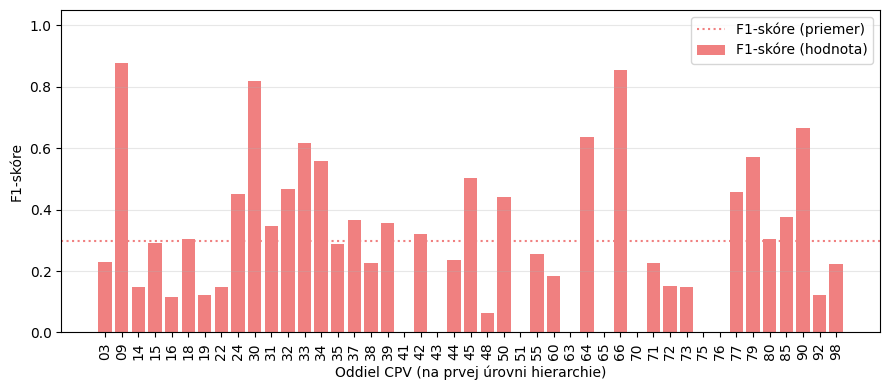

In [55]:
# Vizualizacia stlpcoveho grafu dosiahnutych hodnot F1-skore pre jednotlive oddiely CPV (na prvej urovni)
plt.figure(figsize=(9, 4))

plt.bar(range(len(df_metrics)), df_metrics["f1-score"], color="lightcoral")

plt.xlabel("Oddiel CPV (na prvej úrovni hierarchie)")
plt.xticks(np.arange(len(df_metrics)), df_metrics["cpv_level1_id"].values, rotation=90)
plt.ylabel("F1-skóre")
if (max(df_metrics["f1-score"]) == 1):
    plt.ylim(0, 1)
else:
    plt.ylim(0, 1.05)

plt.axhline(y=df_metrics["f1-score"].mean(), color="lightcoral", linestyle="dotted")

plt.legend(["F1-skóre (priemer)", "F1-skóre (hodnota)"])
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()

plt.show()

V poslednej časti vyhodnotenia klasifikácie sme znázornili maticu zámen (confusion matrix).

In [56]:
replace_func = np.vectorize(lambda x: paired_cpv_levels.get(x, x))
labels_true_45 = replace_func(labels_true)

In [57]:
replace_func = np.vectorize(lambda x: paired_cpv_levels.get(x, x))
labels_predict_45 = replace_func(labels_predict)

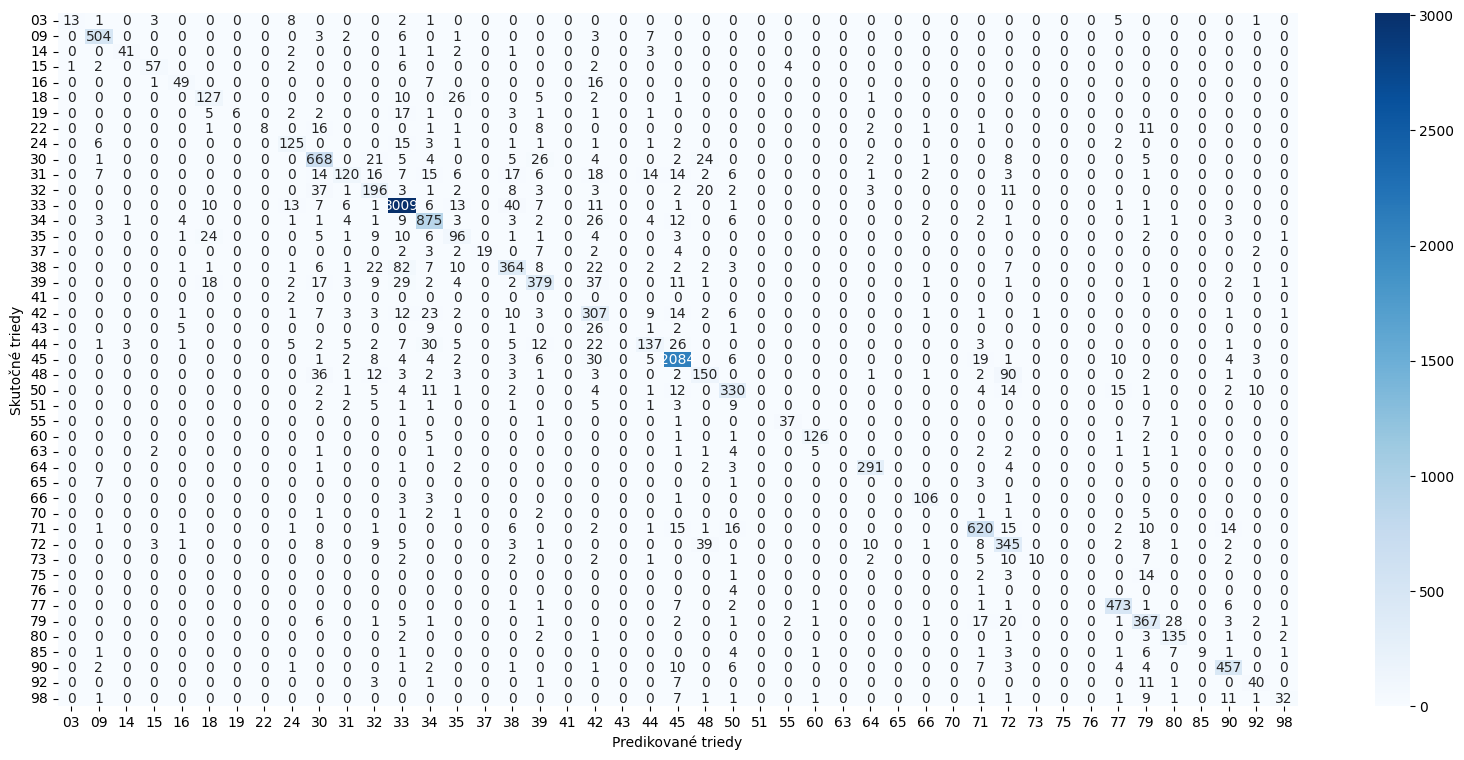

In [58]:
# Vizualizacia matice zamen pomocou heatmap pre 45 oddielov prvej urovne hierarchie CPV
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels_true_45, labels_predict_45)

plt.figure(figsize=(20, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cpv_level1_ids, yticklabels=cpv_level1_ids)
plt.xlabel("Predikované triedy")
plt.ylabel("Skutočné triedy")

plt.show()

Pre ďalšie použitie modelu klasifikácie je vhodné jazykový model uložiť.

In [59]:
# Prihlasenie do Hugging Face Hub prostrednictvom autentifikacneho tokenu
from huggingface_hub import login

login()

In [ ]:
# Definovanie nazvu repozitara pre ulozenie modelu s tokenizerom na Hugging Face
repository_name = "user_name/model_name"

model.push_to_hub(repository_name)
tokenizer.push_to_hub(repository_name)